In [1]:
from collections import defaultdict
import glob
from itertools import groupby
import operator
import os
import re

import numpy as np
import pandas as pd
import pickle
import random
import sparse
#import tensorly as tl
#import tensorly.decomposition as decomp
import sktensor
import urllib3
#import wget

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import logging
logging.basicConfig(level=logging.DEBUG, 
                    format='%(msecs)d %(levelname)-8s [%(lineno)d] %(message)s')

if not os.path.exists('cp_orth.py'):
    wget.download('http://web.stanford.edu/~vsharan/cp_orth.py')
from cp_orth import orth_als

/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
115 DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


In [2]:
projdir = '/mnt/permanent/home/makrai/project/verb-tensor'

In [3]:
def mazsola_reader():
    pickle_path = os.path.join(projdir, 'mazsola.pkl')
    if os.path.exists(pickle_path):
        logging.info('Loading mazsola dict from {}'.format(pickle_path))
        return pickle.load(open(pickle_path, mode='rb'))
    logging.info('Reading mazsola...'.format(pickle_path))
    path = '/mnt/permanent/Language/Hungarian/Dic/sass15-535k-igei-szerkezet/mazsola_adatbazis.txt'
    occurrence = defaultdict(int)#lambda: defaultdict(lambda: defaultdict(int)))
    margianls = [defaultdict(int) for _ in range(3)]
    with open(path) as infile:
        for i, line in enumerate(infile):
            if not i % 500000:
                logging.info('{:.0%}'.format(i/27970403))
            record = defaultdict(str)
            for token in line.strip().split():
                case_stem = re.split('@@', token)
                if len(case_stem) == 1:
                    continue
                try:
                    case, stem = case_stem
                except:
                    logging.warning(line.strip())
                record[case] = stem
            occurrence[record['NOM'], record['stem'], record['ACC']] += 1
            for i, mode in enumerate(['NOM', 'stem', 'ACC']):
                margianls[i][record[mode]] += 1            
    result = occurrence, margianls
    pickle.dump(result, open(pickle_path, mode='wb'))
    return result                

In [4]:
def get_tensor(middle_end='sktensor', cutoff=10):
    logging.info('Reweighting: log')
    verb_tensor_path = os.path.join(projdir, '{}/tensor_{}.pkl'.format(middle_end, cutoff))
    if os.path.exists(verb_tensor_path):
        logging.info('Loading tensor from {}'.format(verb_tensor_path))
        tensor, indices = pickle.load(open(verb_tensor_path, mode='rb'))
        logging.debug(tensor.shape)
        return tensor, indices
    occurrence, marginals = mazsola_reader()
    def get_index(freq_dict):
        items = sorted(filter(lambda item: item[1] >= cutoff, freq_dict.items()), key=operator.itemgetter(1), 
                       reverse=True)
        logging.debug(items[-3:])
        return dict([(w, i) for i, (w, f) in enumerate(items)])

    coords, data = ([], [], []), []
    indices = [get_index(fd) for fd in marginals]
    logging.info('Building tensor...')
    logging.info('  Pupulating lists...')
    for i, ((svo), freq) in enumerate(occurrence.items()):
        if not i % 2000000:
            logging.debug('    {:,}'.format(i))#'{} {}'.format(svo[1], freq))
        for i, word in enumerate(svo):
            if svo[i] not in indices[i]:
                break
        else:
            for i, word in enumerate(svo):
                coords[i].append(indices[i][svo[i]])
            data.append(np.log(freq))
    logging.info('  Creating array')
    shape = tuple(map(len, indices))
    logging.info(shape)
    if middle_end == 'tensorly':
        tensor = sparse.COO(coords, data, shape=shape)#, has_duplicates=False)
    elif middle_end == 'sktensor':
        tensor = sktensor.sptensor(coords, data, shape=shape)
    else:
        raise NotImplementedError
    pickle.dump((tensor, indices), open(verb_tensor_path, mode='wb'))
    logging.info(tensor)
    return tensor, indices

In [5]:
def decomp(cutoff, dim):
    logging.info((cutoff, dim))
    filen_base = os.path.join(projdir, 'sktensor/decomp_{}_{}'.format(cutoff, dim))
    if os.path.isfile('{}.{}'.format(filen_base, 'pkl')) or os.path.isfile('{}.{}'.format(filen_base, 'err')):
        logging.info('File exists {}'.format(glob.glob(filen_base+'.*')))
        return
    vtensor, indices = get_tensor(cutoff=cutoff)
    try:
        result = orth_als(vtensor, dim)
        pickle.dump(result, open('{}.{}'.format(filen_base, 'pkl'), mode='wb'))
    except Exception as e:
        with open('{}.{}'.format(filen_base, 'err'), mode='w') as logfile:
            logging.error(e)
            logfile.write(e)

In [20]:
def show_expers(feature='exectimes'):
    tabular = []
    mx = []
    for filen in glob.glob(os.path.join(projdir, 'sktensor/decomp_*.pkl')):
        _, cutoff, dim = os.path.splitext(filen)[0].split('_')
        cutoff, dim = map(int, (cutoff, dim))
        ktensor, fit, n_iterations, exectimes = pickle.load(open(filen, mode='rb'))
        tabular.append((cutoff, dim, ktensor.shape))
        mx.append([cutoff, dim, sum(exectimes)/60/60])
    mx = np.array(mx)
    print('\n'.join(map(str, sorted(tabular))))
    plt.scatter(np.array(mx).T[0], mx.T[1], c=mx.T[2])
    plt.colorbar()
    plt.xscale('log')

406 DEBUG    [506] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff89fee9ef0>
407 DEBUG    [535] Using auto colorbar locator on colorbar
408 DEBUG    [536] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff89fee9ef0>
409 DEBUG    [692] Setting pcolormesh
413 DEBUG    [2515] update_title_pos
418 DEBUG    [2157] vmin 6.665284687698205 vmax 49118.15245611324
419 DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
428 DEBUG    [2157] vmin 6.665284687698205 vmax 49118.15245611324
429 DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 60000

(10, 2, (64677, 23683, 32896))
(15, 2, (51178, 19617, 25566))
(16, 2, (49356, 19026, 24551))
(16, 3, (49356, 19025, 24551))
(16, 4, (49356, 19025, 24551))
(32, 3, (32708, 13951, 15740))
(32, 4, (32708, 13951, 15740))
(64, 3, (21033, 10294, 9874))
(64, 4, (21033, 10294, 9874))
(128, 3, (13093, 7345, 6116))
(128, 4, (13093, 7345, 6116))
(256, 3, (7957, 5054, 3740))
(256, 4, (7957, 5054, 3740))
(512, 3, (4598, 3269, 2183))
(512, 4, (4598, 3269, 2183))
(1024, 3, (2489, 2084, 1196))
(1024, 4, (2489, 2084, 1196))
(1024, 5, (2489, 2084, 1196))
(1024, 100, (2489, 2084, 1196))
(2048, 3, (1251, 1293, 579))
(2048, 4, (1251, 1293, 579))
(2048, 5, (1251, 1293, 579))
(2048, 6, (1251, 1293, 579))
(2048, 10, (1251, 1293, 579))
(2048, 50, (1251, 1293, 579))
(2048, 100, (1251, 1293, 579))
(4096, 3, (622, 773, 243))
(4096, 4, (622, 773, 243))
(4096, 5, (622, 773, 243))
(4096, 10, (622, 773, 243))
(4096, 100, (622, 773, 243))
(8192, 3, (278, 414, 101))
(8192, 4, (278, 414, 101))
(8192, 5, (278, 414, 101))

570 DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
573 DEBUG    [2157] vmin 6.665284687698205 vmax 49118.15245611324
574 DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
628 DEBUG    [2515] update_title_pos
653 DEBUG    [2157] vmin 6.665284687698205 vmax 49118.15245611324
654 DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
661 DEBUG    [2515] update_title_pos
666 DEBUG    [2157] vmin 6.6

961 DEBUG    [2157] vmin 6.665284687698205 vmax 49118.15245611324
962 DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
967 DEBUG    [2157] vmin 6.665284687698205 vmax 49118.15245611324
967 DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
987 DEBUG    [2515] update_title_pos
0 DEBUG    [2157] vmin 6.665284687698205 vmax 49118.15245611324
1 DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
5 D

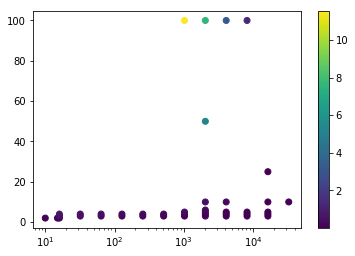

In [21]:
_ = show_expers()

In [7]:
def rand_elem(list1):
    return list1[np.random.randint(0, len(list1))]